#### Lab : Regularization and Linear models

In [59]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from l0bnb import fit_path
import matplotlib.pyplot as plt

#### Subset Selection : 
- Forward
- Backward
- Mixed

### Forward Selection

_Dataset Description_

* `AtBat`: Number of times at bat in 1986
* `Hits`: Number of hits in 1986
* `HmRun`: Number of home runs in 1986
* `Runs`: Number of runs in 1986
* `RBI`: Number of runs batted in in 1986
* `Walks`: Number of walks in 1986
* `Years`: Number of years in the major leagues
* `CAtBat`: Number of times at bat during his career
* `CHits`: Number of hits during his career
* `CHmRun`: Number of home runs during his career
* `CRuns`: Number of runs during his career
* `CRBI`: Number of runs batted in during his career
* `CWalks`: Number of walks during his career
* `League`: A factor with levels A and N indicating player's league at the end of 1986
* `Division`: A factor with levels E and W indicating player's division at the end of 1986
* `PutOuts`: Number of put outs in 1986
* `Assists`: Number of assists in 1986
* `Errors`: Number of errors in 1986
* `Salary`: 1987 annual salary on opening day in thousands of dollars
* `NewLeague`: A factor with levels A and N indicating player's league at the beginning of 1987

Here probably we are going to see how the salary is influenced

In [6]:
data = load_data("Hitters")
data_new = data.dropna()
data_new.shape

(263, 20)

We are doing model selection using $C_p = \frac{\text{RSS} + 2p(\sigma^2)}{n}$ but `sklearn` doesn't define it. So we need to compute it ourselves. 

Function : 
- `sklearn_selected(model, strategy).fit(data, y)` -> Expects a scorer with just 3 arguments
- `Stepwise()` -> To specify the search strategy
- `Stepwise.first_peak(design, direction, max_terms)` -> Runs forward stepwise until forward stepwise don't result in any improvements

In [23]:
def C_p(sigma2, estimator, x, y) : 
    n, p = x.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

# First we need to estimate sigma2 - fitting the biggest model
design = MS(data_new.columns.drop("Salary")).fit(data_new)
y = data_new["Salary"]
x = design.transform(data_new)
sigma2 = sm.OLS(y, x).fit().scale

# Fixing the sigma2 
neg_cp = partial(C_p, sigma2)

# Strategy : ISLP Specific
strategy = Stepwise.first_peak(design, direction = "forward", max_terms=len(design.terms))
hitters = sklearn_selected(sm.OLS, strategy)
hitters.fit(data_new, y)
hitters.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

Choosing models using `Validation` & `CrossValidation`, but to implement this we need something that can store the full path of the models and we can estimate error using the full path. 
- `sklearn_selection_path()` & `cross_val_predict()` computes the cross validated predictions

Using CV to make the determination of which model of a given size is best must be made using training observations

In [25]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction = "forward")
full = sklearn_selection_path(sm.OLS, strategy)
full.fit(data_new, y)
yhat = full.predict(data_new)
yhat.shape # Fitted value of the array of the full path.

(263, 20)

In [81]:
kfold = skm.KFold(5, shuffle = True, random_state = 0)
yhat_cv = skm.cross_val_predict(full, data_new, y, cv = kfold)
cv_mse = []

for train_idx, test_idx in kfold.split(y) : 
    errors = ((yhat_cv[test_idx] - y[test_idx, None])**2).mean(0)
    cv_mse.append(errors)
    
cv_mse = np.array(cv_mse).T
cv_mse.shape


(20, 5)

In [94]:
valfold = skm.ShuffleSplit(1, random_state = 0)
val_mse = []

for train_idx, test_idx in valfold.split(y) : 
    full.fit(data_new.iloc[train_idx], y[train_idx])
    yhat_val = full.predict(data_new.iloc[test_idx])
    errors = ((yhat_val - y[test_idx, None])**2).mean(0)
    val_mse.append(errors)
    
val_mse = np.array(val_mse).T
val_mse.shape

(20, 1)

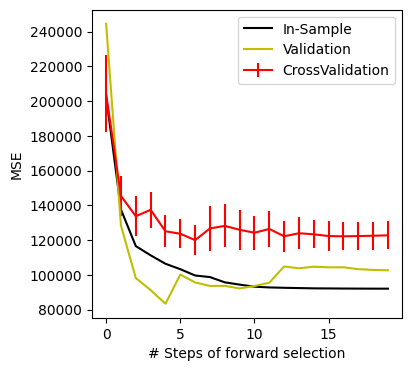

In [96]:
# Plotting the MSE
mse, ax = subplots(figsize = (4,4))
y = np.array(data_new["Salary"])
mse_sample = ((yhat -y[:, None])**2).mean(0) # y[:,None] -> make a column vector.
n = mse_sample.shape[0]
ax.plot(np.arange(n),mse_sample, label = "In-Sample", color = "k")
ax.set_xlabel("# Steps of forward selection")
ax.set_ylabel("MSE")
ax.errorbar(np.arange(n), cv_mse.mean(1), cv_mse.std(1)/ np.sqrt(5), label = "CrossValidation", c = "r")
ax.plot(np.arange(n), val_mse.mean(1), label = "Validation", c = "y")
ax.legend()
plt.show()

Best subset selection using `l0bnb` & `fit_path`

In [100]:
# Beyond scope of this book

d = design.fit_transform(data_new)
de = d.drop("intercept", axis = 1)
x = np.asarray(de)
path = fit_path(x,y,max_nonzeros=x.shape[1])
path

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


[{'B': array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.77543616, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]),
  'B0': 279.70762133645695,
  'lambda_0': 0.1559978371476548,
  'M': 0.5558487113898553,
  'Time_exceeded': False},
 {'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.67775265, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]),
  'B0': -38.98216739555551,
  'lambda_0': 0.04917594600171587,
  'M': 0.6670111294490764,
  'Time_exceeded': False},
 {'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.67775265, 0.        , 0.        , 0.        ,
         0.  